<h1>2D and 3D plots in Julia with Plots</h1>

<p>This covers plotting the typical 2D and 3D plots in Julia with the <code>Plots</code> package.</p>

In [1]:
using Plots
using LinearAlgebra, ForwardDiff
import PyPlot
import Contour: contours, levels, lines, coordinates

<p>We will make use of some helper functions that will simplify plotting. These will be described in more detail in the following:</p>

In [1]:
xs_ys(vs) = (A=hcat(vs...); Tuple([A[i,:] for i in eachindex(vs[1])]))
xs_ys(v,vs...) = xs_ys([v, vs...])
xs_ys(r::Function, a, b, n=100) = xs_ys(r.(range(a, stop=b, length=n)))

function arrow!(p, v; kwargs...)
  if length(p) == 2
     quiver!(xs_ys([p])..., quiver=Tuple(xs_ys([v])); kwargs...)
  elseif length(p) == 3
    # 3d quiver needs support
    # https://github.com/JuliaPlots/Plots.jl/issues/319#issue-159652535
    # headless arrow instead
    plot!(xs_ys(p, p+v)...; kwargs...)
	end
end

arrow! (generic function with 1 method)

<p>We will also use the <code>ForwardDiff</code> for derivatives and use the "prime" notation:</p>

In [1]:
using ForwardDiff
function D(f, n::Int=1)
    n < 0 && throw(ArgumentError("n is a non-negative integer"))
    n == 0 && return f
    n == 1 && return t -> ForwardDiff.derivative(f, float(t))
    D(D(f), n-1)
end
Base.adjoint(r::Function) = D(r)

<p>We will need to manipulate contours directly, so pull in the <code>Contours</code> package, using <code>import</code> to avoid name collisions and explicitly listing the methods we will use:</p>

In [1]:
import Contour: contours, levels, lines, coordinates

<p>Finally, we need some features for vectors:</p>

In [1]:
using LinearAlgebra

<h2>Parametrically described curves in space</h2>

<p>Let $r(t)$ be a vector-valued function with values in $R^d$, $d$ being $2$ or $3$. A familiar example is the equation for a line that travels in the direction of $\vec{v}$ and goes through the point $P$: $r(t) = P + t \cdot \vec{v}$. A <em>parametric plot</em> over $[a,b]$ is the collection of all points $r(t)$ for $a \leq t \leq b$.</p>

<p>In <code>Plots</code>, parameterized curves can be plotted through two interfaces, here illustrated for $d=2$: <code>plot&#40;f1, f2, a, b&#41;</code> or <code>plot&#40;xs, ys&#41;</code>. The former is convenient for some cases, but typically we will have a function <code>r&#40;t&#41;</code> which is vector-valued, as opposed to a vector of functions. As such, we only discuss the latter.</p>

<p>An example helps illustrate. Suppose $r(t) = \langle \sin(t), \cos(2t) \rangle$ and the goal is to plot the full ellipse by plotting over $0 \leq t \leq 2\pi$. As with plotting of curves, the goal would be to take many points between <code>a</code> and <code>b</code> and from there generate the $x$ values and $y$ values.</p>

<p>Let's see this with 5 points, the first and last being identical due to the curve:</p>

In [1]:
r(t) = [sin(t), cos(2t)]
ts = range(0, stop=2pi, length=5)

0.0:1.5707963267948966:6.283185307179586

<p>Then we can create the $5$ points easily through broadcasting:</p>

In [1]:
vs = r.(ts)

5-element Array{Array{Float64,1},1}:
 [0.0, 1.0]         
 [1.0, -1.0]        
 [1.22465e-16, 1.0] 
 [-1.0, -1.0]       
 [-2.44929e-16, 1.0]

<p>This returns a vector of points (stored as vectors). The plotting function wants two collections: the set of $x$ values for the points and the set of $y$ values. The data needs to be generated differently or reshaped. The function <code>xs_ys</code> above takes data in this style and returns the desired format, returning a tuple with the $x$ values and $y$ values pulled out:</p>

In [1]:
xs_ys(vs)

([0.0, 1.0, 1.22465e-16, -1.0, -2.44929e-16], [1.0, -1.0, 1.0, -1.0, 1.0])

<p>To plot this, we "splat" the tuple so that <code>plot</code> gets the arguments separately:</p>

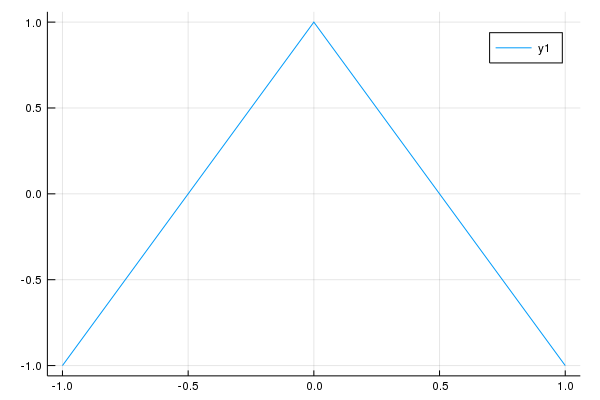

In [1]:
plot(xs_ys(vs)...)

<p>This  basic plot is lacking, of course, as there are not enough points. Using more initially is a remedy. Rather than generate the <code>ts</code> separately, <code>xs_ys</code> has a simple frontend <code>xs_ys&#40;r, a, b&#41;</code> which does this work itself:</p>

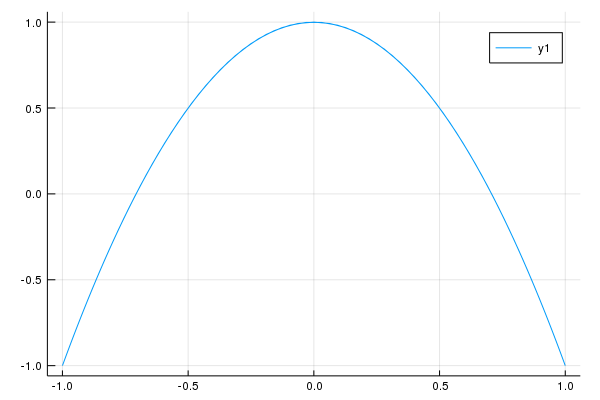

In [1]:
plot(xs_ys(r, 0, 2pi, 100)...)

<h3>Plotting a space curve in 3 dimensions</h3>

<p>A parametrically described curve in 3D is similarly created. For example, a helix is described mathematically by $r(t) = \langle sin(t), cos(t), t \rangle$. Here we graph two turns:</p>

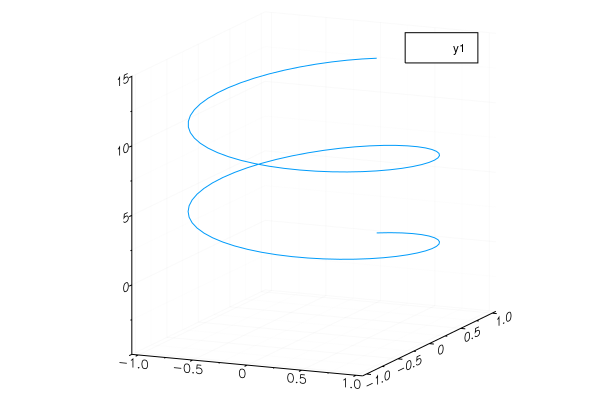

In [1]:
r(t) = [sin(t), cos(t), t]
plot(xs_ys(r, 0, 4pi)...)

<h3>Adding a vector</h3>

<p>The tangent vector indicates the instantaneous direction one would travel were they walking along the space curve. We can add a tangent vector to the graph. The <code>quiver&#33;</code> function would be used to add a 2D vector, but <code>Plots</code> does not currently have a <code>3D</code> analog. In addition, <code>quiver&#33;</code> has a somewhat cumbersome calling pattern when adding just one vector. So we have the <code>arrow&#33;</code> function defined above that uses <code>quiver</code> for 2D arrows and a simple line for 3D arrows. As a vector incorporates magnitude and direction, but not a position, <code>arrow&#33;</code> needs both a point for the position and a vector.</p>

<p>Here is how we can visualize the tangent vector at a few points on the helix:</p>

In [1]:
plot(xs_ys(r, 0, 4pi)..., legend=false)
ts = range(0, 4pi, length=5)
for t in ts
   arrow!(r(t), r'(t))
end

In [1]:
note("""Adding many arrows this way would be inefficient.""")

<div class="alert alert-info" role="alert">

<div class="markdown"><p>Adding many arrows this way would be inefficient.</p>
</div>

</div>


<h3>Setting a viewing angle for 3D plots</h3>

<p>For 3D plots, the viewing angle can make the difference in visualizing the key features. In <code>Plots</code>, some backends allow the viewing angle to be set with the mouse by clicking and dragging. Not all do. For such, the <code>camera</code> argument is used, as in <code>camera&#40;azimuthal, elevation&#41;</code> where the angles are given in degrees. If the $x$-$y$-$z$ coorinates are given, then <code>elevation</code> or <em>inclination</em>, is the angle between the $z$ axis and the $x-y$ plane (so <code>90</code> is a top view) and <code>azimuthal</code> is the angle in the $x-y$ plane from the $x$ axes.</p>

<h2>Visualizing functions from $R^2 \rightarrow R$</h2>

<p>If a function $f: R^2 \rightarrow R$ then a graph of $(x,y,f(x,y))$ can be represented in 3D. It will form a surface. Such graphs can be most simply made by specifying a set of $x$ values, a set of $y$ values and a function $f$, as with:</p>

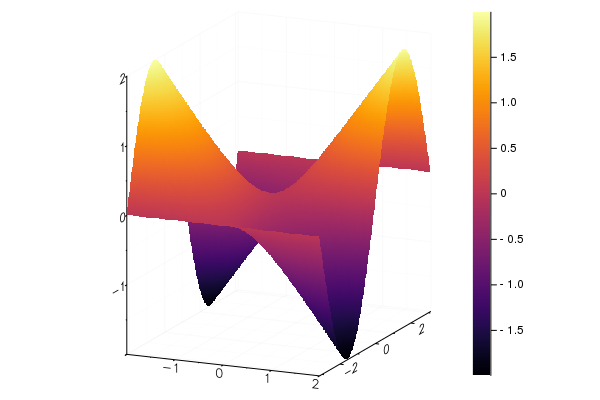

In [1]:
xs = range(-2, stop=2, length=100)
ys = range(-pi, stop=pi, length=100)
f(x,y) = x*sin(y)
surface(xs, ys, f)

<p>Rather than pass in a function, values can be passed in. Here they are generated with a list comprehension. The <code>y</code> values are innermost to match the graphic when passing in a function object:</p>

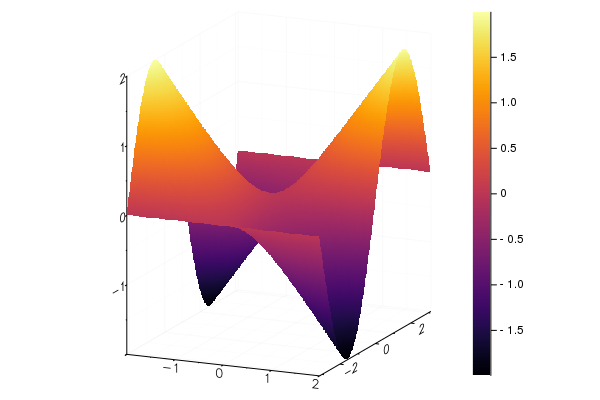

In [1]:
zs = [f(x,y) for y in ys, x in xs]
surface(xs, ys, zs)

<h3>Contour plots</h3>

<p>The contour plot of $f:R^2 \rightarrow R$ draws level curves, $f(x,y)=c$, for different values of $c$ in the $x-y$ plane. They are produced in a similar manner as the surface plots:</p>

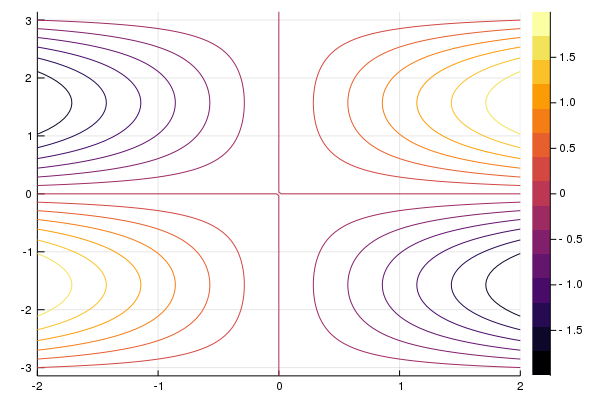

In [1]:
contour(xs, ys, f)

<p>The cross in the middle corresponds to $c=0$, as when $x=0$ or $y=0$ then $f(x,y)=0$.</p>

<p>Similarly, computed values for $f(x,y)$ can be passed in. Here we change the function:</p>

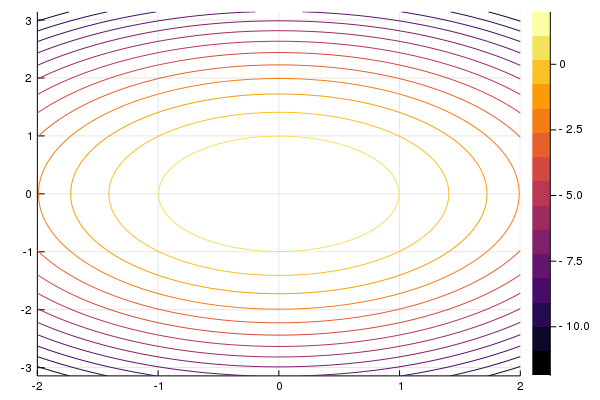

In [1]:
f(x,y) = 2 - (x^2 + y^2)
zs = [f(x,y) for y in ys, x in xs]
contour(xs, ys, zs)

<p>The chosen levels can be specified by the user through the <code>levels</code> argument, as in:</p>

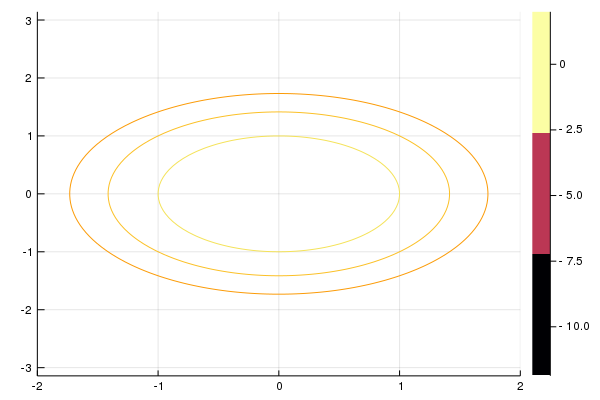

In [1]:
gr()
contour(xs, ys, zs, levels = [-1.0, 0.0, 1.0])

<p>If only a single level is desired, as scalar value can be specified. For example, this next graphic shows the $0$-level of the [devil]](http://www-groups.dcs.st-and.ac.uk/~history/Curves/Devils.html)'s curve.</p>

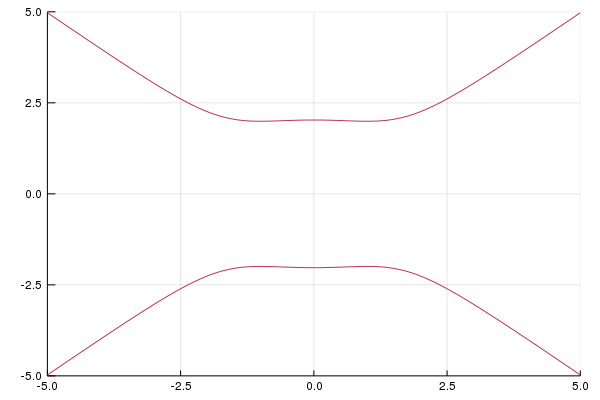

In [1]:
gr()
a, b = -1, 2
f(x,y) = y^4 - x^4 + a*y^2 + b*x^2
xs = ys = range(-5, stop=5, length=100)
contour(xs, ys, f, levels=0)

<p>Contour plots are well known from the presence of contour lines on many maps. Contour lines indicate constant elevations. A peak is characterized by a series of nested closed paths. The following graph shows this for the peak at $(x,y)=(0,0)$.</p>

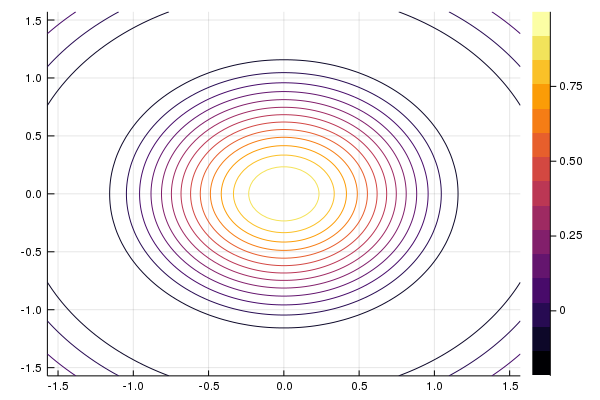

In [1]:
#plotly()
xs = ys = range(-pi/2, stop=pi/2, length=100)
f(x,y) = sinc(sqrt(x^2 + y^2))   # sinc(x) is sin(x)/x
contour(xs, ys, f)

<p>Contour plots can be filled with colors through the <code>contourf</code> function:</p>

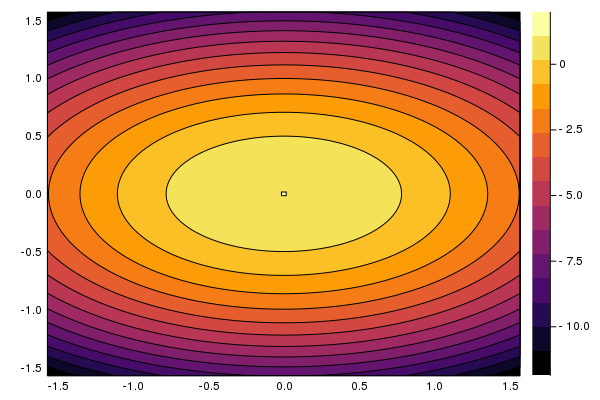

In [1]:
contourf(xs, ys, zs)

<h3>Combining surface plots and contour plots</h3>

<p>In <code>PyPlot</code> it is possible to add a contour lines to the surface, or projected onto an axis. Here is an example:</p>

In [1]:
import PyPlot
xs = ys = range(-2, stop=2, length=100)
f(x,y) = 2 + x^2 + y^2
zs = [f(x,y) for y in ys, x in xs]
PyPlot.plot_surface(xs, ys, zs)
PyPlot.contour3D(xs, ys, zs)
ax = PyPlot.gca()
ax.contour(xs, ys, zs, offset=0)

PyObject <matplotlib.contour.QuadContourSet object at 0x1426ee320>

<p>To replicate something similar, though not as satisfying, in <code>Plots</code> we use the <code>Contour</code> package.</p>

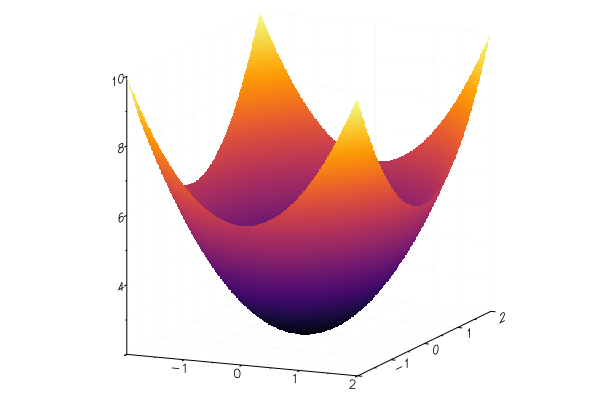

In [1]:
import Contour
xs = ys = range(-2, stop=2, length=100)
f(x,y) = 2 + x^2 + y^2
zs = [f(x,y) for y in ys, x in xs]
p = surface(xs, ys, zs, legend=false, fillalpha=0.5)

## we add to the graphic p, then plot
for cl in levels(contours(xs, ys, zs))
    lvl = level(cl) # the z-value of this contour level
    for line in lines(cl)
        _xs, _ys = coordinates(line) # coordinates of this line segment
        _zs = 0 * _xs
        plot!(p, _xs, _ys, lvl .+ _zs, alpha=0.5) # add on surface
        plot!(p, _xs, _ys, _zs, alpha=0.5)        # add on x-y plane
    end
end
p

<p>There is no hidden line calculuation, in place we give the contour lines a transparency through the argument <code>alpha&#61;0.5</code>.</p>

<h3>Gradient and surface plots</h3>

<p>The surface plot of $f: R^2 \rightarrow R$ plots $(x, y, f(x,y))$ as a surface. The <em>gradient</em> of $f$ is $\langle \partial f/\partial x, \partial f/\partial y\rangle$. It is a two-dimensional object indicating the direction at a point $(x,y)$ where the surface has the greatest ascent. Illurating the gradient and the surface on the same plot requires embedding the 2D gradient into the 3D surface. This can be done by adding a constant $z$ value to the gradient, such as $0$.</p>

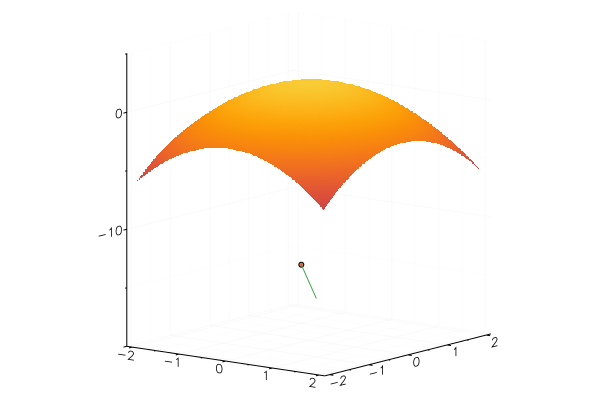

In [1]:
f(x,y) = 2 - (x^2 + y^2)
xs = ys = range(-2, stop=2, length=100)
zs = [f(x,y) for y in ys, x in xs]

surface(xs, ys, zs, camera=(40, 25), legend=false)
p = [-1, 1] # in the region graphed, [-2,2] × [-2, 2]

f(x) = f(x...)
v = ForwardDiff.gradient(f, p)


# add 0 to p and v (two styles)
push!(p, -15)
scatter!(xs_ys([p])..., markersize=3)

v = vcat(v, 0)
arrow!(p, v)

<h3>The tangent plane</h3>

<p>Let $z = f(x,y)$ describe a surface, and $F(x,y,z) = f(x,y) - z$. The the gradient of $F$ at a point $p$ on the surface, $\nabla F(p)$, will be normal to the surface and for a function, $f(p) + \nabla f \cdot (x-p)$ describes the tangent plane. We can visualize each, as follows:</p>

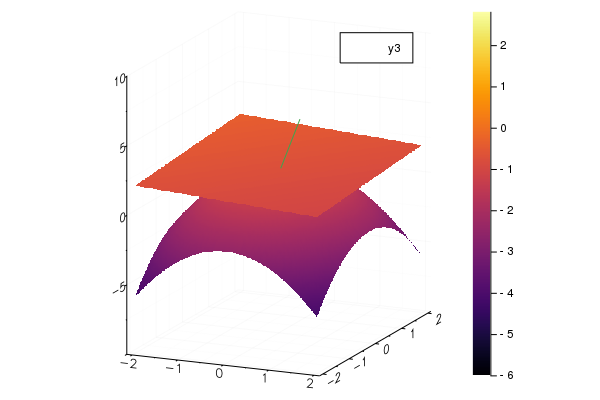

In [1]:
f(x,y) = 2 - x^2 - y^2
F(x,y,z) = z - f(x,y)
F(x) = F(x...)
p = [1/10, -1/10]
p1 = vcat(p, f(p...)) # note F(p1) == 0
n = ForwardDiff.gradient(F, p1)
tl(x) = f(p) +  ForwardDiff.gradient(f, p) ⋅ (x - p)
tl(x,y) = tl([x,y])

xs = ys = range(-2, stop=2, length=100)
surface(xs, ys, f)
surface!(xs, ys, tl)
arrow!(p1, 5n)

<p>From some viewing angles, the normal does not look perpendicular to the tangent plane. This is a quick verification for a randomly chosen point in the $x-y$ plane:</p>

In [1]:
a, b = randn(2)
dot(n, (p1-[a,b,tl(a,b)]))

1.1102230246251565e-16

<h3>Parameterized surface plots</h3>

<p>As illustrated, we can plot surfaces of the form $(x,y,f(x,y)$. However, not all surfaces are so readily described. For example, if $F(x,y,z)$ is a function from $R^3 \rightarrow R$, then $F(x,y,z)=c$ is a surface of interest. For example, the sphere of radius one is a solution to $F(x,y,z)=1$ where $F(x,y,z) =  x^2 + y^2 + z^2$.</p>

<p>Plotting such generally described surfaces is not so easy, but <em>parameterized</em> surfaces can be represented. For example, the sphere as a surface is not represented as a surface of a function, but can be represented in spherical coordinates as parameterized by two angles, essentially an "azimuth" and and "elevation", as used with the <code>camera</code> argument.</p>

<p>Here we define functions that represent $(x,y,z)$ coordinates in terms of the corresponding spherical coordinates $(r, \theta, \phi)$.</p>

In [1]:
# spherical: (radius r, inclination θ, azimuth φ)
X(r,theta,phi) = r * sin(theta) * sin(phi)
Y(r,theta,phi) = r * sin(theta) * cos(phi)
Z(r,theta,phi) = r * cos(theta)

Z (generic function with 1 method)

<p>We can parameterize the sphere by plotting values for $x$, $y$, and $z$ produced by a sequence of values for $\theta$ and $\phi$, holding $r=1$:</p>

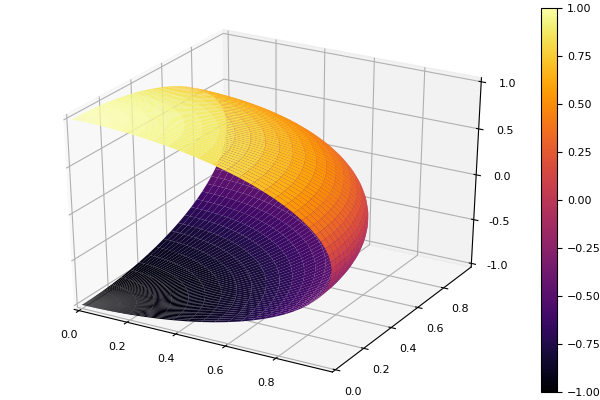

In [1]:
pyplot()
thetas = range(0, stop=pi,   length=50)
phis   = range(0, stop=pi/2, length=50)

xs = [X(1, theta, phi) for theta in thetas, phi in phis]
ys = [Y(1, theta, phi) for theta in thetas, phi in phis]
zs = [Z(1, theta, phi) for theta in thetas, phi in phis]

surface(xs, ys, zs)

In [1]:
note("The above may not work with all backends for `Plots`, even if those that support 3D graphics.")

<div class="alert alert-info" role="alert">

<div class="markdown"><p>The above may not work with all backends for <code>Plots</code>, even if those that support 3D graphics.</p>
</div>

</div>


<h3>Plotting  F(x,y, z) = c</h3>

<p>There is no built in functionality in <code>Plots</code> to create surface described by $F(x,y,z) = c$. An example of how to provide some such functionality for <code>PyPlot</code> appears <a href="https://stackoverflow.com/questions/4680525/plotting-implicit-equations-in-3d ">here</a>. The following implements the same approach for <code>Plots</code>.</p>

In [1]:
gr()
function plot_implicit(F, c=0;
                       xrng=(-5,5), yrng=xrng, zrng=xrng,
                       nlevels=6,         # number of levels in a direction
                       slices=Dict(:x => :blue,
                                   :y => :red,
                                   :z => :green), # which directions and color
                       kwargs...          # passed to initial `plot` call
                       )

    _linspace(rng, n=150) = range(rng[1], stop=rng[2], length=n)

    X1, Y1, Z1 = _linspace(xrng), _linspace(yrng), _linspace(zrng)

    p = Plots.plot(;legend=false,kwargs...)

    if :x ∈ keys(slices)
        for x in _linspace(xrng, nlevels)
            local X1 = [F(x,y,z) for y in Y1, z in Z1]
            cnt = contours(Y1,Z1,X1, [c])
            for line in lines(levels(cnt)[1])
                ys, zs = coordinates(line) # coordinates of this line segment
                plot!(p, x .+ 0 * ys, ys, zs, color=slices[:x])
          end
        end
    end

    if :y ∈ keys(slices)
        for y in _linspace(yrng, nlevels)
            local Y1 = [F(x,y,z) for x in X1, z in Z1]
            cnt = contours(Z1,X1,Y1, [c])
            for line in lines(levels(cnt)[1])
                xs, zs = coordinates(line) # coordinates of this line segment
                plot!(p, xs, y .+ 0 * xs, zs, color=slices[:y])
            end
        end
    end

    if :z ∈ keys(slices)
        for z in _linspace(zrng, nlevels)
            local Z1 = [F(x, y, z) for x in X1, y in Y1]
            cnt = contours(X1, Y1, Z1, [c])
            for line in lines(levels(cnt)[1])
                xs, ys = coordinates(line) # coordinates of this line segment
                plot!(p, xs, ys, z .+ 0 * xs, color=slices[:z])
            end
        end
    end


    p
end

plot_implicit (generic function with 2 methods)

<p>To use it, we see what happens when a sphere if rendered:</p>

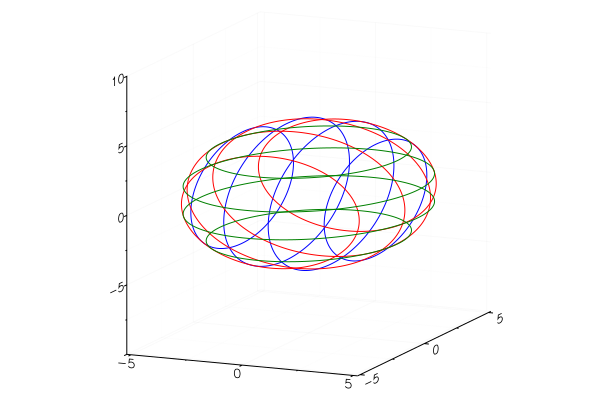

In [1]:
f(x,y,z) = x^2 + y^2 + z^2 - 25
plot_implicit(f)

<p>The graphic is a bit hard to read. Showing only 1 set of slices with more levels can lead to an improvement:</p>

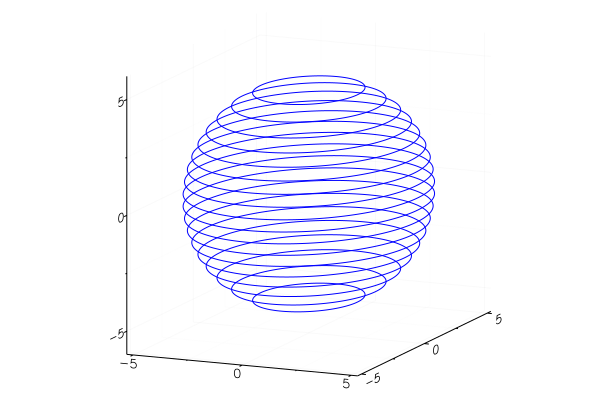

In [1]:
plot_implicit(f, nlevels=20, slices=Dict(:z=>:blue))

<p>This figure comes from a February 14, 2019 article in the <a href="https://www.nytimes.com/2019/02/14/science/math-algorithm-valentine.html">New York Times</a>. It shows an equation for a "heart," as the graphic will illustrate:</p>

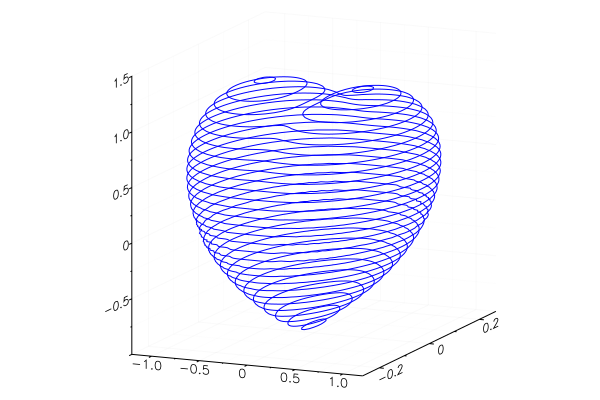

In [1]:
a,b = 1,3
f(x,y,z) = (x^2+((1+b)*y)^2+z^2-1)^3-x^2*z^3-a*y^2*z^3
plot_implicit(f, xrng=(-2,2),yrng=(-1,1),zrng=(-1,2),
   nlevels=40, slices=Dict(:z=>:blue))

<h2>Vector fields</h2>

<p>Consider a function $f: R^2 \rightarrow R$. The gradient function, $\nabla f$ is a function from $R^2$ into $R^2$. Such functions can be visualized in terms of a vector field. For each point, $p$, the  gradient (or a scaled version) is indicated by anchoring it at $p$. This is typically done for a grid of values. In the code below, we scale the size of each vector so that they stay within the grid.</p>

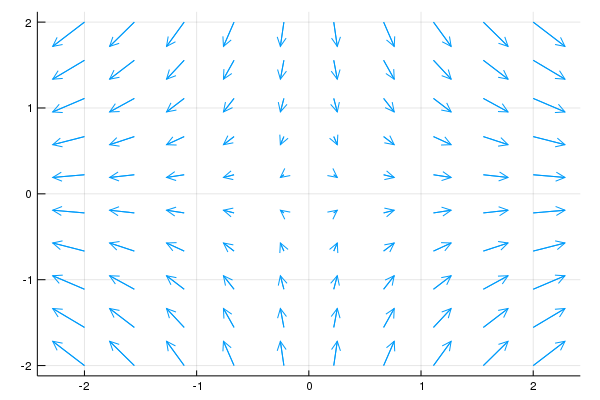

In [1]:
using LinearAlgebra

f(x,y) = x^2 - y^2
f(x) = f(x...)
xs = ys = range(-2, stop=2, length=10)

ps = [[x,y] for x in xs, y in ys]
vs = [ForwardDiff.gradient(f, p) for p in ps]

# scale the vs
m = maximum(norm.(vs))
vs = 4/10/m * vs

quiver(xs_ys(ps)..., quiver=xs_ys(vs))

<p>We see the use of <code>quiver</code> to add vectors in 2D. The <code>ps</code> need to be specified as <code>xs, ys</code>, hence the splatting, whereas the <code>quiver</code> <em>argument</em> expects a tuple of vectors, hence no splatting. Calling <code>quiver</code> this way, as opposed to adding individual lines through <code>arrow</code>, say, is much more efficient.</p>

<p>The scale used is simply computed. The points are spaced evenly with $4/10$ units between them.  The longest vector will have this length, so will not be able to leave the cell, hence the vectors won't overlap, as would happen with this example otherwise.</p>

<p>One last comment, in place of the comprehension to form the <code>vs</code>, broadcasting, as with <code>vs &#61; ForwardDiff.gradient.&#40;f, ps&#41;</code>, could be used.</p>